# Анализ новостей с обученной BERT (hugging face)

Цель этого задания-использовать предварительно обученную модель BERT для классификации новостей.

 Датасет содержит заголовок, текст новости и бинарную метку  (настоящая/фейковая).

-Использована библиотека HuggingFace дляз агрузки предварительно обученной модели BERT и токенизатора.

-Подготовка данных: использован токенизатор BERT для преобразования текстовых данных в формат, который можно подать на вход модели BERT.

-Создан классификатор на снове BERT:это может быть модель BERT с одним линейным слоем для классификации на вершине.

-Обучен классификатор на данных обучения и оценена его производительность на данных для тестирования.


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.2 MB/s eta 0:00:00


In [ ]:
# импорт необходимых библиотек

import pandas as pd # табличное представление и чтение|запись csv
import numpy as np # векторы, матрицы
import random # случайный генератор
import time # измерение времени

# предобработка текста
import nltk
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # токенизация по словам

from sklearn.model_selection import train_test_split # разделение на тестовую и тренировочную выборки
import re # удаление знаков препинания через регулярное выражение

# нейронные слои
import torch
import torch.nn as nn # настройка нейросети (класс родитель)
import torch.optim as optim # оптимизация
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler # объекты настройки
import torch.nn.functional as F # функция softmax

# трансформеры, предобученные
from transformers import BertModel # класс модели BERT
from transformers import AdamW, get_linear_schedule_with_warmup # оптимизатор и загрузчик
from transformers import BertTokenizer, BertForSequenceClassification # Токенизатор, классификатор

from sklearn.metrics import accuracy_score, roc_curve, auc # метрики классификации

In [ ]:
import matplotlib.pyplot as plt # график, визуализация

In [ ]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

In [ ]:
nltk.download('stopwords') # стоп-слова
nltk.download('punkt') # пунктуация


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Загрузка датасета

https://www.kaggle.com/datasets/nopdev/real-and-fake-news-dataset

In [ ]:
df_BERT1 = pd.read_csv('news.csv')

In [ ]:
df_BERT1

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


#Выберем текст самой новости и метку

In [ ]:
# Создание нового датафрейма с двумя выбранными колонками
df_BERT = df_BERT1[['text', 'label']]

In [ ]:
df_BERT

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [ ]:
# рассмотрим информацию о датасете
df_BERT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6335 non-null   object
 1   label   6335 non-null   object
dtypes: object(2)
memory usage: 99.1+ KB


In [ ]:
# выведем первые 10 строк датасета
df_BERT.head(10)

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
5,"\nI’m not an immigrant, but my grandparents ...",FAKE
6,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,A Czech stockbroker who saved more than 650 Je...,REAL
8,Hillary Clinton and Donald Trump made some ina...,REAL
9,Iranian negotiators reportedly have made a las...,REAL


In [ ]:
# рассмотрим сводную статистическую информацию о датасете
df_BERT.describe()

,text,label
count,6335,6335
unique,6060,2
top,"Killing Obama administration rules, dismantlin...",REAL
freq,58,3171


#Предобработка текста

In [ ]:
# удалим знаки препинания и приведем к нижнему регистру
df_BERT['text'] = df_BERT['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

<ipython-input-31-2d29b927c469>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BERT['text'] = df_BERT['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))


In [ ]:
stop_words = set(stopwords.words('english'))
# по DataFrame в цикле столбец и внести изменения
df_BERT['text'] = df_BERT['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

<ipython-input-32-1bcf01a09b7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BERT['text'] = df_BERT['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))


In [ ]:
df_BERT

,text,label
0,daniel greenfield shillman journalism fellow f...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,us secretary state john f kerry said monday st...,REAL
3,kaydee king kaydeeking november 9 2016 lesson ...,FAKE
4,primary day new york frontrunners hillary clin...,REAL
...,...,...
6330,state department told republican national comm...,REAL
6331,p pbs stand plutocratic pentagon posted oct 27...,FAKE
6332,antitrump protesters tools oligarchy reform al...,FAKE
6333,addis ababa ethiopia president obama convened ...,REAL


In [ ]:
# замена пробелов на нижнее подчеркивание
df_BERT['text'] = df_BERT['text'].str.replace(' ', '_')

#df_BERT

<ipython-input-34-1141e49b9af0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BERT['text'] = df_BERT['text'].str.replace(' ', '_')


In [ ]:
df_BERT

,text,label
0,daniel_greenfield_shillman_journalism_fellow_f...,FAKE
1,google_pinterest_digg_linkedin_reddit_stumbleu...,FAKE
2,us_secretary_state_john_f_kerry_said_monday_st...,REAL
3,kaydee_king_kaydeeking_november_9_2016_lesson_...,FAKE
4,primary_day_new_york_frontrunners_hillary_clin...,REAL
...,...,...
6330,state_department_told_republican_national_comm...,REAL
6331,p_pbs_stand_plutocratic_pentagon_posted_oct_27...,FAKE
6332,antitrump_protesters_tools_oligarchy_reform_al...,FAKE
6333,addis_ababa_ethiopia_president_obama_convened_...,REAL


In [ ]:
# проверим уникальные метки тональности
print(df_BERT['label'].unique())

['FAKE' 'REAL']


In [ ]:
# преобразуем 'label' в числовой формат
df_BERT['label'] = df_BERT['label'].map({'FAKE': 0, 'REAL': 1})
df_BERT

<ipython-input-37-4b240ecfc5c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BERT['label'] = df_BERT['label'].map({'FAKE': 0, 'REAL': 1})


,text,label
0,daniel_greenfield_shillman_journalism_fellow_f...,0
1,google_pinterest_digg_linkedin_reddit_stumbleu...,0
2,us_secretary_state_john_f_kerry_said_monday_st...,1
3,kaydee_king_kaydeeking_november_9_2016_lesson_...,0
4,primary_day_new_york_frontrunners_hillary_clin...,1
...,...,...
6330,state_department_told_republican_national_comm...,1
6331,p_pbs_stand_plutocratic_pentagon_posted_oct_27...,0
6332,antitrump_protesters_tools_oligarchy_reform_al...,0
6333,addis_ababa_ethiopia_president_obama_convened_...,1


In [ ]:
# разделение данных на тренировочную (70%) и тестовую (30%) выборки
x = df_BERT['text']
y = df_BERT['label']

x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.3, random_state=42)

In [ ]:
# рассмотрим информацию о размерах выборок
print("Размеры тренировочной выборки:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")

print("Размеры тестовой выборки:")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

Размеры тренировочной выборки:
x_train: (4434,), y_train: (4434,)
Размеры тестовой выборки:
x_test: (1901,), y_test: (1901,)


#Загрузка предварительно обученной модели BERT

In [ ]:
# загрузка предварительно обученной модели BERT
BERT_HUGGING_MODEL = 'bert-base-uncased'

In [ ]:
# загрузка предварительно обученного токенизатора BERT
tokenizer = BertTokenizer.from_pretrained(BERT_HUGGING_MODEL, do_lower_case=True) # нижний регистр

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased'] # максимальная max_length

print(max_input_length)

512


In [ ]:
# cоздаем функцию для токенизации текста
def preprocessing_for_bert(data):
    """Выполним необходимые предварительные шаги обработки данных для предварительно обученной модели BERT.
    @param    data (np.array): Массив текстов для обработки.
    @return   input_ids (torch.Tensor): Тензор идентификаторов токенов, который будет передан в модель.
    @return   attention_masks (torch.Tensor): Тензор индексов, указывающий, на какие
                  токены должна обращать внимание модель.
    """

    # создаем пустые списки для хранения результатов
    input_ids = []
    attention_masks = []

    # для каждого предложения...
    for sent in data:
        # Функция `encode_plus` выполнит следующие шаги:
        # 1. Токенизация предложения.
        # 2. Добавление токенов `[CLS]` и `[SEP]` в начало и конец.
        # 3. Усечение/дополнение предложения до максимальной длины.
        # 4. Сопоставление токенов и их идентификаторов.
        # 5. Создание маски внимания.
        # 6. Возврат словаря результатов.

        encoded_sent = tokenizer.encode_plus(
            sent,                           # Предобработанный текст, исходные
            add_special_tokens=True,        # Добавление `[CLS]` и `[SEP]`
            max_length=MAX_LEN,             # Максимальная длина для усечения/дополнения
            pad_to_max_length=True,         # Дополнение предложения до максимальной длины
            return_attention_mask=True      # Возврат маски внимания
        ) # {'input_ids':[...], 'attention_mask': [...]}

        # добавляем результаты в соответствующие списки
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # преобразуем списки в тензоры
    input_ids = torch.tensor(input_ids) # обертка в тензор
    attention_masks = torch.tensor(attention_masks) # обертка в тензор

    return input_ids, attention_masks

In [ ]:
# рассмотрим тренировочные и тестовые данные, формат DataFrame
print("Тренировочные данные (x_train):")
print(x_train)

print("\nТестовые данные (x_test):")
print(x_test)

Тренировочные данные (x_train):
2771    months_uncertainty_donald_trump_committed_part...
6049    25_views_november_10_2016_gold_kwn_king_world_...
731     trump_proposals_seem_startling_killing_terrori...
5835    holed_saudi_arabia_inner_circle_president_hadi...
291     propalestinian_propaganda_lowering_standards_t...
                              ...                        
3772    happened_less_debate_among_contenders_showdown...
5191    clinton_fbigate_true_depth_obamageddon_3110201...
5226    fearing_election_day_trouble_us_schools_cancel...
5390    president_obamas_appearance_town_hall_meeting_...
860     man_protests_international_trade_agreements_tt...
Name: text, Length: 4434, dtype: object

Тестовые данные (x_test):
1357    trump_pull_brexit_times_ten_would_take_beyond_...
2080    clintons_multiple_fbi_investigations_agents_st...
2718    dispatches_eric_zuesse_piece_crossposted_strat...
812     print_ed_every_facade_cracks_somebody_asks_que...
4886    nanny_jail_force_feedin

In [ ]:
# задаем максимальную длину последовательности
MAX_LEN = 128

# применим функцию 'preprocessing_for_bert' на тренировочном наборе данных и тестовом наборе данных
train_inputs, train_masks = preprocessing_for_bert(x_train)
test_inputs, test_masks = preprocessing_for_bert(x_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# рассморим информацию о 'train_masks' и 'train_inputs'
print("train_masks:")
print(train_masks)

print("\ntrain_inputs:")
print(train_inputs)

train_masks:
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

train_inputs:
tensor([[  101,  2706,  1035,  ...,  3951,  1035,   102],
        [  101,  2423,  1035,  ...,  1035,  7483,   102],
        [  101,  8398,  1035,  ...,  3458,  1035,   102],
        ...,
        [  101, 14892,  1035,  ...,  7079,  1035,   102],
        [  101,  2343,  1035,  ...,  9527,  1035,   102],
        [  101,  2158,  1035,  ...,  1035,  3808,   102]])


In [ ]:
# создаем DataLoader для тренировочных и тестовых данных

# преобразуем объект Series или DataFrame перекодировать в массивы NumPy
if isinstance(y_train, pd.Series):
    y_train=y_train.to_numpy()

if isinstance(y_test, pd.Series):
    y_test=y_test.to_numpy()

# создаем тензоры PyTorch для меток
train_labels = torch.LongTensor(y_train)
test_labels = torch.LongTensor(y_test)

# определим размер batch size (16 или 32)
batch_size = 16

# создание 'RandomSampler' и 'DataLoader'
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#Создаем классификатор на основе BERT

In [ ]:
# создаем классификатор на основе BERT
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.3), LSTM, GRU
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # смотрим CLS - начало предложения (определяем отзыв)
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)
        return logits

In [ ]:
# инициализируем модель
EPOCH_NUM = 5

def initialize_model(epochs=EPOCH_NUM):
    # создаем экземпляр BertClassifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # задаем устройство (GPU T4)
    bert_classifier.to(device)

    # создаем оптимизатор
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,
                      eps=1e-8
                      )

    # делаем расчет циклов для работы
    total_steps = len(train_dataloader) * epochs

    # загрузчик, расписание (последовательность) и число циклов для обучения
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
# определим функцию обучения модели

# функция потерь (бинарная классификация), не бинарная - заменить функцию
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=1):
  '''
  Воспроизводимость модели, по умолчанию seed_value=42
  '''
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=EPOCH_NUM, evaluation=False):
    """

      Тренировка BertClassifier model

    """
    print("Начало тренировки...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # измерение времени (elapsed time of each epoch)
        t0_epoch, t0_batch = time.time(), time.time()

        # обнулить переменные
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # перевод в режим тренировки
        model.train()

        # для каждого batch
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # загружаем каждую batch в GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # использование нулевого градиента
            model.zero_grad()

            # добавляем в модель id и маски
            logits = model(b_input_ids, b_attn_mask)

            # считаем потери (Кросс Энтропия)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # расчет градиентов функцией backward
            loss.backward()

            # решение проблемы "взрывных градиентов"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # обновляем шаг для оптимизатора и расписания
            optimizer.step()
            scheduler.step()

            # печатаем значения для каждых 20 batch
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # время расчета 20 batches
                time_elapsed = time.time() - t0_batch

                # результаты
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # обнулим переменные
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # средняя функция потерь
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Оценка
        # =======================================
        if evaluation == True:
            # считается точность
            test_loss, test_accuracy = evaluate(model, test_dataloader)

            # общее время, затраченное на измерение
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Тренировка завершена!")

In [ ]:
# определим функцию вычисления показателей качества модели (функцию потерь и точность)
def evaluate(model, test_dataloader):

    model.eval()

    test_accuracy = []
    test_loss = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [ ]:
# определяем устройство для модели
device = torch.device("cuda")

# Обучение модели

In [ ]:
# обучение модели
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.600317   |     -      |     -     |   7.81   
   1    |   40    |   0.419890   |     -      |     -     |   6.64   
   1    |   60    |   0.308362   |     -      |     -     |   6.73   
   1    |   80    |   0.261431   |     -      |     -     |   6.86   
   1    |   100   |   0.359304   |     -      |     -     |   6.94   
   1    |   120   |   0.333387   |     -      |     -     |   7.01   
   1    |   140   |   0.285565   |     -      |     -     |   7.32   
   1    |   160   |   0.313020   |     -      |     -     |   7.37   
   1    |   180   |   0.228890   |     -      |     -     |   7.48   
   1    |   200   |   0.214146   |     -      |     -     |   7.65   
   1    |   220   |   0.258455   |     -      |     -     |   7.88   
   1    |   240   |   0.231225   |     -      |     -     |   8.11 

In [ ]:
# загрузим натренированную модель
def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Сбор из каждого batch результатов в один объект
    all_logits = torch.cat(all_logits, dim=0)

    # Для вероятности принадлежности к классу
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# построим график ROC-кривой для наглядной оценки качества предсказания
def evaluate_roc(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # ROC AUC
    plt.title('Оценка ROC AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#Оценка качества

AUC: 0.9847
Accuracy: 94.16%


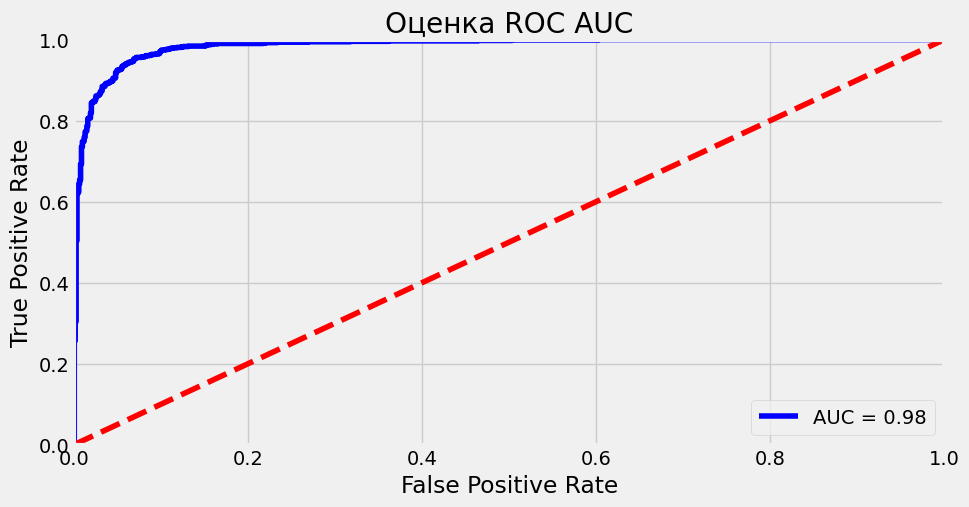

In [ ]:
# вычислим предсказанные вероятности на тестовых данных
probs = bert_predict(bert_classifier, test_dataloader) # оценка занимает время

# оценим Bert classifier
evaluate_roc(probs, y_test)

#Вывод - неплохо

#Теперь попробуем разные архитектуры сети

1) добавим слой Dropout

In [ ]:
# создаем классификатор на основе BERT

class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.3),  # Добавлен слой Dropout
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
# обучение модели
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.699596   |     -      |     -     |   8.27   
   1    |   40    |   0.644161   |     -      |     -     |   8.16   
   1    |   60    |   0.619959   |     -      |     -     |   8.44   
   1    |   80    |   0.665063   |     -      |     -     |   8.31   
   1    |   100   |   0.703196   |     -      |     -     |   8.13   
   1    |   120   |   0.608516   |     -      |     -     |   7.94   
   1    |   140   |   0.570619   |     -      |     -     |   7.91   
   1    |   160   |   0.470893   |     -      |     -     |   7.64   
   1    |   180   |   0.473976   |     -      |     -     |   7.62   
   1    |   200   |   0.342734   |     -      |     -     |   7.63   
   1    |   220   |   0.444059   |     -      |     -     |   7.69   
   1    |   240   |   0.372955   |     -      |     -     |   7.74 

AUC: 0.9800
Accuracy: 93.53%


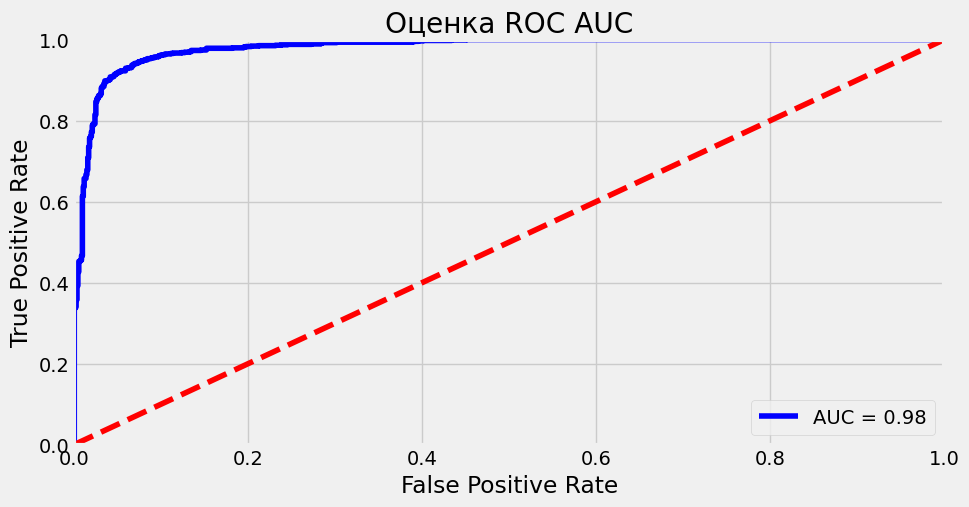

In [ ]:
# вычислим предсказанные вероятности на тестовых данных
probs = bert_predict(bert_classifier, test_dataloader) # оценка занимает время

# оценим Bert classifier
evaluate_roc(probs, y_test)

#Вывод - качество ухудшилось

#Попробуем добавить еще один линейный слой

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, H),  # Добавлен слой
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
# обучение модели
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.694713   |     -      |     -     |   8.57   
   1    |   40    |   0.668528   |     -      |     -     |   8.45   
   1    |   60    |   0.606287   |     -      |     -     |   8.31   
   1    |   80    |   0.603324   |     -      |     -     |   8.01   
   1    |   100   |   0.651377   |     -      |     -     |   7.82   
   1    |   120   |   0.642850   |     -      |     -     |   7.66   
   1    |   140   |   0.569669   |     -      |     -     |   7.59   
   1    |   160   |   0.552203   |     -      |     -     |   7.57   
   1    |   180   |   0.502023   |     -      |     -     |   7.59   
   1    |   200   |   0.486589   |     -      |     -     |   7.66   
   1    |   220   |   0.510072   |     -      |     -     |   7.74   
   1    |   240   |   0.467927   |     -      |     -     |   7.83 

AUC: 0.9737
Accuracy: 91.11%


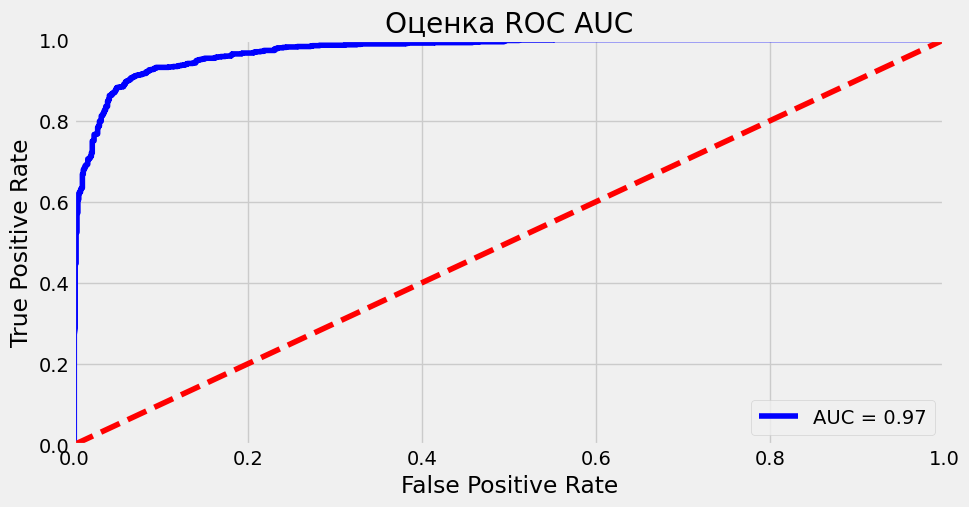

In [ ]:
# вычислим предсказанные вероятности на тестовых данных
probs = bert_predict(bert_classifier, test_dataloader) # оценка занимает время

# оценим Bert classifier
evaluate_roc(probs, y_test)

#Вывод - стало еще хуже

#А теперь оставим два линейных слоя, но добавим Dropout

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, H),  # Добавлен слой
            nn.ReLU(),
            nn.Dropout(0.3),  # Добавлен слой Dropout
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
# обучение модели
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.681322   |     -      |     -     |   8.60   
   1    |   40    |   0.584988   |     -      |     -     |   8.52   
   1    |   60    |   0.548645   |     -      |     -     |   8.37   
   1    |   80    |   0.547162   |     -      |     -     |   8.04   
   1    |   100   |   0.496558   |     -      |     -     |   7.85   
   1    |   120   |   0.499952   |     -      |     -     |   7.71   
   1    |   140   |   0.467341   |     -      |     -     |   7.65   
   1    |   160   |   0.448096   |     -      |     -     |   7.61   
   1    |   180   |   0.374425   |     -      |     -     |   7.61   
   1    |   200   |   0.337347   |     -      |     -     |   7.72   
   1    |   220   |   0.319383   |     -      |     -     |   7.75   
   1    |   240   |   0.358806   |     -      |     -     |   7.85 

AUC: 0.9831
Accuracy: 93.85%


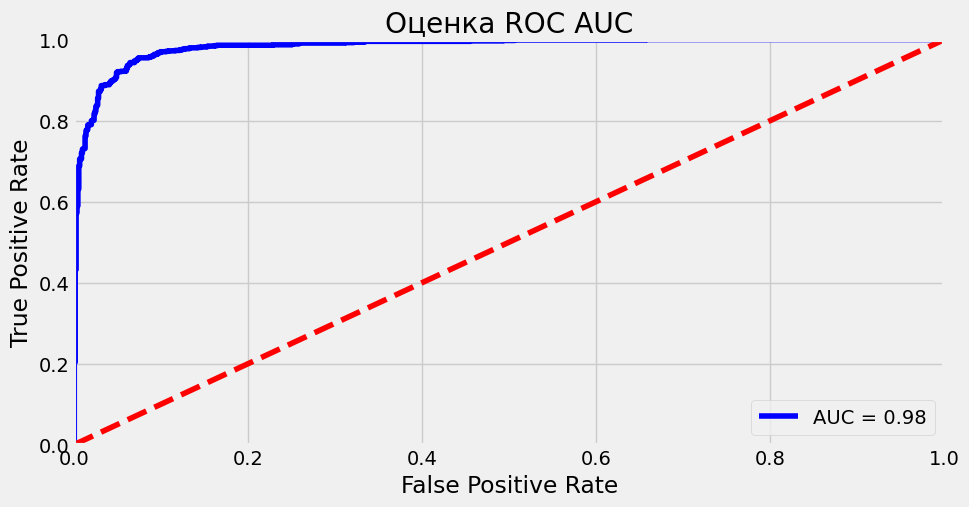

In [ ]:
# вычислим предсказанные вероятности на тестовых данных
probs = bert_predict(bert_classifier, test_dataloader) # оценка занимает время

# оценим Bert classifier
evaluate_roc(probs, y_test)

#Вывод - качество лучше, чем в предыдущих двух случаях, но все равно хуже, чем было в самом первом варианте.
То есть добавление одного линейного слоя, и дообучение его показало на этих данных самые лучшие результаты.